In [1]:
!date

Mon Nov  9 11:37:40 PST 2020


# Subclass regression merfish

In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from scipy.spatial import ConvexHull
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

import sys
sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/trackfig')
from trackfig.utils import get_notebook_name
from trackfig.trackfig import trackfig 

TRACKFIG = "/home/sina/projects/mop/BYVSTZP_2020/trackfig.txt"
NB = get_notebook_name()

sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

import warnings
warnings.filterwarnings('ignore')

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})
    
    return ax


In [3]:
def nd(arr):
    return np.asarray(arr).reshape(-1)

def line(x, c0, c1):
    return c0+x*c1

In [4]:
def non_increasing(L):
    return all(x>=y for x, y in zip(L, L[1:]))

def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))

def monotonic(L):
    return non_increasing(L) or non_decreasing(L)

In [5]:
mfish = anndata.read_h5ad("../../data/notebook/revision/merfish-updated.h5ad")

In [6]:
mfish

AnnData object with n_obs × n_vars = 280327 × 254
    obs: 'fovID', 'fov_x', 'fov_y', 'volume', 'center_x', 'center_y', 'slice_id', 'sample_id', 'label', 'subclass', 'class_label', 'cell_id'
    var: 'n_iso'
    layers: 'X', 'log1p', 'norm'

In [7]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"other" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
"Ependymal":     (0.596078431372549,   0.8745098039215686,  0.5411764705882353  ),  # 98df8a
"L4/5_IT": "#846239",
"Macrophages": (0.6196078431372549,  0.6039215686274509,  0.7843137254901961  ),  # 9e9ac8
"Microglia":     (0.17254901960784313, 0.6274509803921569,  0.17254901960784313 ),  # 2ca02c,
"OPC": (0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
"Oligodendrocytes": (0.8549019607843137,  0.8549019607843137,  0.9215686274509803  ) , # dadaeb
"Pericytes": "pink",
"Sst_Chodl": "#c6efef",
}



In [8]:
le = LabelEncoder()
mfish.obs["subclass_id"] = le.fit_transform(mfish.obs.subclass.values)

In [9]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

In [10]:
slice_id = mfish.obs.slice_id.values
slice_id = np.unique(slice_id)

In [11]:
unique_map = {'Astrocytes': "Astro",
'Endothelial':"Endo",
'SMC':"SMC",
'L23_IT':"L2/3 IT",
'VLMC': "VLMC",
'L6_CT': "L6 CT",
'L45_IT': "L4/5 IT",
'L5_PT': "L5 PT",
'L5_IT': "L5 IT",
'Sst': "Sst",
'L6_IT': "L6 IT",
'Sncg': "Sncg",
'L6_IT_Car3': "L6 IT Car3",
'Vip': "Vip",
'L56_NP': "L5/6 NP",
'Pvalb': "Pvalb",  
'L6b': "L6b",
'Lamp5': "Lamp5"}

inv_map = {v: k for k, v in unique_map.items()}

In [12]:
mfish.obs.subclass = mfish.obs.subclass.apply(lambda x: unique_map.get(x,x))

In [13]:
unique_subclass = np.unique(mfish.obs.subclass)

unique_subclass

array(['Astro', 'Endo', 'L2/3 IT', 'L4/5 IT', 'L5 IT', 'L5 PT', 'L5/6 NP',
       'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b', 'Lamp5', 'Microglia', 'OPC',
       'Oligodendrocytes', 'PVM', 'Pericytes', 'Pvalb', 'SMC', 'Sncg',
       'Sst', 'Sst_Chodl', 'VLMC', 'Vip', 'other'], dtype=object)

In [14]:
the_chosen_one = 7

In [15]:
mfish.obs

,fovID,fov_x,fov_y,volume,center_x,center_y,slice_id,sample_id,label,subclass,class_label,cell_id,subclass_id
0,13,4539.310,2986.899,992.830060,4738.397298,3075.327399,mouse2_slice31,dataset2_sample4,Astro_1,Astro,Other,0,0
1,290,-4016.860,1404.780,610.091871,-3964.711404,1451.889047,mouse2_slice160,dataset2_sample5,Endo,Endo,Other,1,1
2,113,750.406,1143.102,148.277718,805.843523,1215.035473,mouse2_slice109,dataset2_sample6,SMC,SMC,Other,2,18
3,432,1262.680,-3752.030,249.515471,1348.686198,-3589.955255,mouse1_slice71,dataset1_sample2,Endo,Endo,Other,3,1
4,354,-3627.450,-1987.730,1779.831996,-3584.650904,-1883.105955,mouse2_slice219,dataset2_sample5,L23_IT_3,L2/3 IT,Glutamatergic,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
280322,386,774.760,913.600,1208.963097,890.666985,1069.905972,mouse1_slice251,dataset1_sample5,Pvalb_1,Pvalb,GABAergic,280322,17
280323,327,1910.380,1079.280,611.167089,1913.334949,1280.947292,mouse2_slice261,dataset2_sample3,L5_PT_5,L5 PT,Glutamatergic,280323,6
280324,89,3659.910,3432.540,130.928366,3847.387896,3589.662245,mouse1_slice112,dataset1_sample3,L45_IT_4,L4/5 IT,Glutamatergic,280324,3
280325,300,2510.380,1279.280,799.847696,2728.208220,1376.136296,mouse2_slice261,dataset2_sample3,L5_PT_2,L5 PT,Glutamatergic,280325,6


In [16]:
chosen = mfish[mfish.obs.eval(f"slice_id == '{slice_id[the_chosen_one]}'").values]

In [17]:
chosen

View of AnnData object with n_obs × n_vars = 6963 × 254
    obs: 'fovID', 'fov_x', 'fov_y', 'volume', 'center_x', 'center_y', 'slice_id', 'sample_id', 'label', 'subclass', 'class_label', 'cell_id', 'subclass_id'
    var: 'n_iso'
    layers: 'X', 'log1p', 'norm'

In [18]:
cluster_order = [
    "L5 IT",
    "L5/6 NP",
    "L5 PT", 
    "L2/3 IT",
    "L6b",
    "L6 IT",
    "L6 CT",
    "L6 IT Car3",
    "Lamp5",
    "Sncg",
    "Vip",
    "Sst",
    "Pvalb",
     "Endo"
]

In [19]:
# compute the points in the upper hull
x = chosen.obs["center_x"].values
y = chosen.obs["center_y"].values

points = np.array([x, y]).T
hull = ConvexHull(points)
hull_x = np.array(points[hull.vertices,0].tolist() + [points[hull.vertices,0].tolist()[0]])
hull_y = np.array(points[hull.vertices,1].tolist() + [points[hull.vertices,1].tolist()[0]])

# slice specific
min_hull_idx = 6
max_hull_idx = 15
hx = hull_x[min_hull_idx:max_hull_idx]
hy = hull_y[min_hull_idx:max_hull_idx]


# fit a line to the upper hull and get coefficients of line
# in the form Ax+By+C = 0
reg = LinearRegression().fit(hx[:, np.newaxis], hy)
regx = np.linspace(hx.min(), hx.max(), 100)
A = -reg.coef_[0]
B = 1
C = -reg.intercept_

In [20]:
def dist2line(A, B, C, x0, y0):
    return np.abs(A*x0+B*y0+C)/np.sqrt(A**2+B**2)

def nearestpoint(A, B, C, x0, y0):
    x = (B*(B*x0 - A*y0) - A*C)/(A**2 + B**2)
    y = (A*(-B*x0 + A*y0) - B*C)/(A**2 + B**2)
    return (x, y)

In [21]:
# Get centroids and their distance from the boundary line
def get_depth(df):
    x = df["center_x"].values
    y = df["center_y"].values
    
    # plot the boundary
    cx = x.mean()
    cy = y.mean()
    
    depth = dist2line(A, B, C, cx, cy)
    nearx, neary = nearestpoint(A, B, C, cx, cy)
    n_cells = x.shape[0]
    return depth

In [22]:
df = pd.DataFrame(chosen.obs.groupby("subclass").apply(get_depth), columns=["centroid_depth"])

df["n_cells"] = df.index.map(chosen.obs.groupby("subclass")["subclass_id"].count()).values

df["normalized_depth"] = df.centroid_depth/df.centroid_depth.max()

In [23]:
df.head()

,centroid_depth,n_cells,normalized_depth
subclass,,,
Astro,771.277445,546,0.446167
Endo,778.359023,505,0.450264
L5 IT,887.832511,441,0.513592
L5 PT,956.311804,185,0.553205
L6 CT,1185.278379,582,0.685658


CPU times: user 549 ms, sys: 22.2 ms, total: 572 ms
Wall time: 570 ms


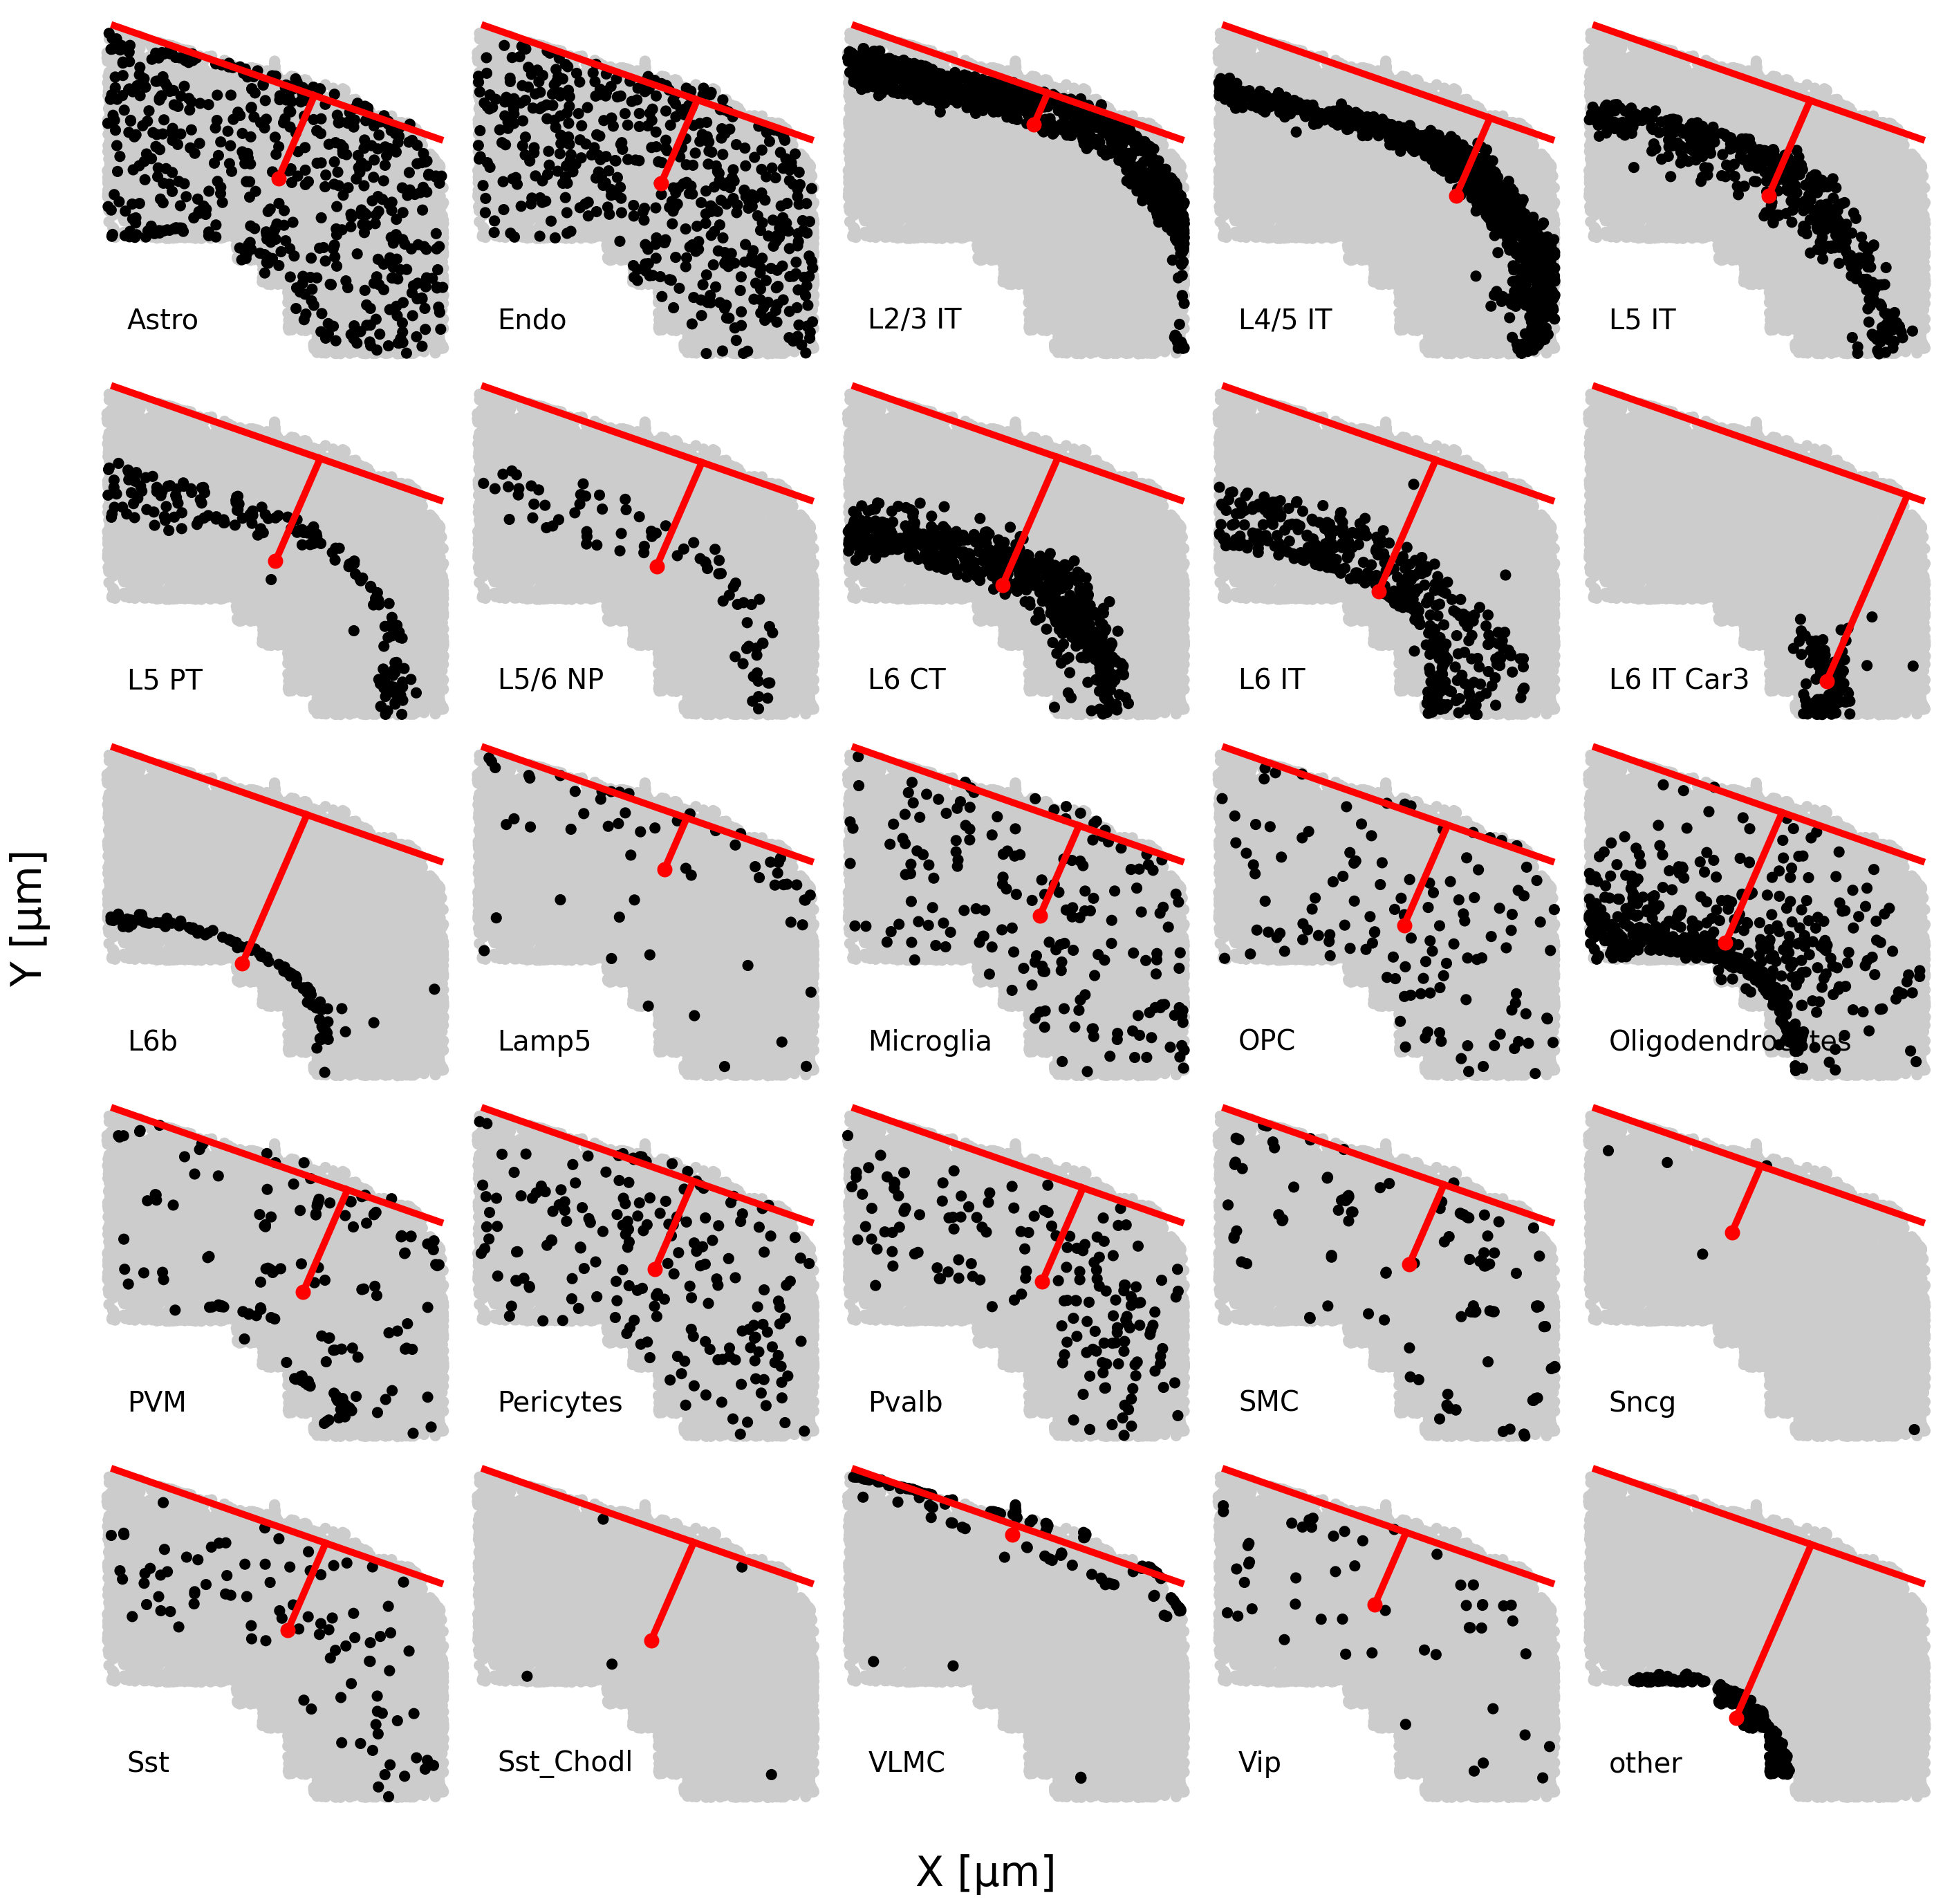

In [24]:
%%time
fig, ax = plt.subplots(figsize=(24,24), ncols=5, nrows=5)
fig.subplots_adjust(hspace=0, wspace=0)

n_subclasses = len(unique_subclass)

axs = trim_axs(ax, len(slice_id))
ss_labels = chosen.obs.subclass.values

# build a rectangle in axes coords
left = .1
bottom = .1

for cidx, (ax, cluster) in enumerate(zip(axs, unique_subclass)):
    x = chosen.obs["center_x"].values
    y = chosen.obs["center_y"].values
    c = np.ones(x.shape[0])*0.1
    
    cmask = ss_labels == cluster
    
    # plot the boundary
    cx = x[cmask].mean()
    cy = y[cmask].mean()
    
    ax.scatter(cx, cy, color="r", s=100, zorder=10)
    nearx, neary = nearestpoint(A, B, C, cx, cy)
    ax.plot([cx, nearx], [cy, neary], color="red", linewidth=5)
    ax.plot(regx, reg.intercept_ + reg.coef_*regx, color="red", linewidth=5)
    
    
    c[cmask] = 1
    
    argsort = np.argsort(c)
    x = x[argsort]
    y = y[argsort]
    c = c[argsort]
    
    ax.scatter(x, y, c=c, cmap="nipy_spectral_r", s=50)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    

    ax.set_axis_off()
    ax.set_ylabel(cluster)
    
    ax.text(left, bottom, f'{cluster}',
            horizontalalignment='left',
            verticalalignment='bottom',
            transform=ax.transAxes)
fig.text(0.5, 0.1, 'X [µm]', ha='center', va='center', fontsize=30)
fig.text(0.1, 0.5, 'Y [µm]', ha='center', va='center', rotation='vertical', fontsize=30)

#plt.savefig(trackfig("../../figures/merfish_single_slice_layer_depth.png", TRACKFIG, NB), bbox_inches='tight', dpi=300)


fig.show()

In [25]:
isoform = anndata.read_h5ad("../../data/notebook/revision/isoform.h5ad")

In [26]:
isoform.obs.query("class_label=='Glutamatergic' and subclass_label!='L5 IT'").subclass_label.unique()

[L5/6 NP, L2/3 IT, L6 IT, L6 CT, L6b, L5 PT, L6 IT Car3]
Categories (7, object): [L5/6 NP, L2/3 IT, L6 IT, L6 CT, L6b, L5 PT, L6 IT Car3]

In [27]:
isoform.obs

,cluster_id,cluster_label,subclass_label,class_label,cluster_color,size,cell_id,subclass_id,class_id,cell_counts,leiden,louvain
0,10,Vip Chat_1,Vip,GABAergic,#FF00FF,33,LS-15395_S47_E1-50,17,0,998372.1875,5,6
1,38,L5 IT S100b_2,L5 IT,Glutamatergic,#2F8C4D,83,LS-15395_S48_E1-50,3,1,998955.6875,10,10
2,4,Lamp5 Slc35d3,Lamp5,GABAergic,#FFA388,194,LS-15395_S49_E1-50,10,0,998189.4375,9,9
3,38,L5 IT S100b_2,L5 IT,Glutamatergic,#2F8C4D,83,LS-15395_S50_E1-50,3,1,999028.6250,10,10
4,20,Sst Myh8_2,Sst,GABAergic,#D27A2A,55,LS-15395_S51_E1-50,15,0,998751.8750,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...
6575,25,Pvalb Reln,Pvalb,GABAergic,#BC2D71,292,SM-GE935_S380_E1-50,12,0,998965.1875,2,3
6576,7,Sncg,Sncg,GABAergic,#9900B3,77,SM-GE935_S381_E1-50,14,0,998525.5000,12,12
6577,16,Vip Gpc3,Vip,GABAergic,#B94DA7,43,SM-GE935_S382_E1-50,17,0,998407.3750,5,6
6578,12,Vip Chat_3,Vip,GABAergic,#FF0CFF,87,SM-GE935_S383_E1-50,17,0,998484.3750,5,6


# Regression, depth and isoform expression

In [28]:
mtx = isoform.layers["log1p"].todense()
components = isoform.obs.subclass_label.values
features = isoform.var.transcript_name.values

In [29]:
unique_subclass = df.sort_values("centroid_depth").index.values

In [30]:
layers = [
    "L2/3 IT",
#    "L5 IT",
    "L5 PT",
    "L5/6 NP",
    "L6 CT",
    "L6 IT",
    "L6b",
    "L6 IT Car3",
]

In [31]:
# get all of the isoform subclass groupings for each layer and only keep 
# the isoforms for which all subclasses have non-zero expression
all_data = []
names = []
for iidx, i in enumerate(features):
    vec = nd(mtx[:,features == i])
    
    exp = []
    data = [vec[components == c] for c in layers]
    if np.sum([(i>0).sum()> i.shape[0]*0.9 for i in data]) == len(data):
        all_data.append(data)
        names.append(i)

In [32]:
# perform weighted linear regression and get pvalues on the F-score, using the variance as the weight

markers_depth = pd.DataFrame(columns=["name", "intercept", "coef", "p_f", "p_f_corr", "p_coef", "p_coef_corr", "rsq", "rsq_adj", "monotonic"], index = np.arange(len(all_data)))

n_cells = isoform.obs.subclass_label.value_counts().loc[layers].values

X = np.repeat(df.loc[layers]["normalized_depth"].values, n_cells)
XX = sm.add_constant(X)

for idx, data in enumerate(all_data):
    W = [i.var() for i in data]
    weights = np.repeat(W, n_cells)
    Y = np.concatenate(data)

    est = sm.WLS(Y, XX, weights=1/weights).fit()
    
    const, x1 = est.params
    
    markers_depth.iloc[idx]["name"] = names[idx]
    markers_depth.iloc[idx]["intercept"] = const
    markers_depth.iloc[idx]["coef"] = x1
    
    markers_depth.iloc[idx]["p_f"] = est.f_pvalue
    markers_depth.iloc[idx]["p_coef"] = est.pvalues[1]
    markers_depth.iloc[idx]["monotonic"] = monotonic([i.mean() for i in data])
    
    markers_depth.iloc[idx]["rsq"] = est.rsquared
    markers_depth.iloc[idx]["rsq_adj"] = est.rsquared_adj
    
    
    

markers_depth["p_f_corr"] = multipletests(markers_depth["p_f"], alpha=0.01, method="bonferroni")[1]
markers_depth["p_coef_corr"] = multipletests(markers_depth["p_coef"], alpha=0.01, method="bonferroni")[1]
# convert the 0 pvalues to the smallest possible float
markers_depth["p_f_corr"][markers_depth.eval("p_f_corr == 0").values] = sys.float_info.min

In [33]:
alpha=0.01

In [34]:
np.log10(alpha)

-2.0

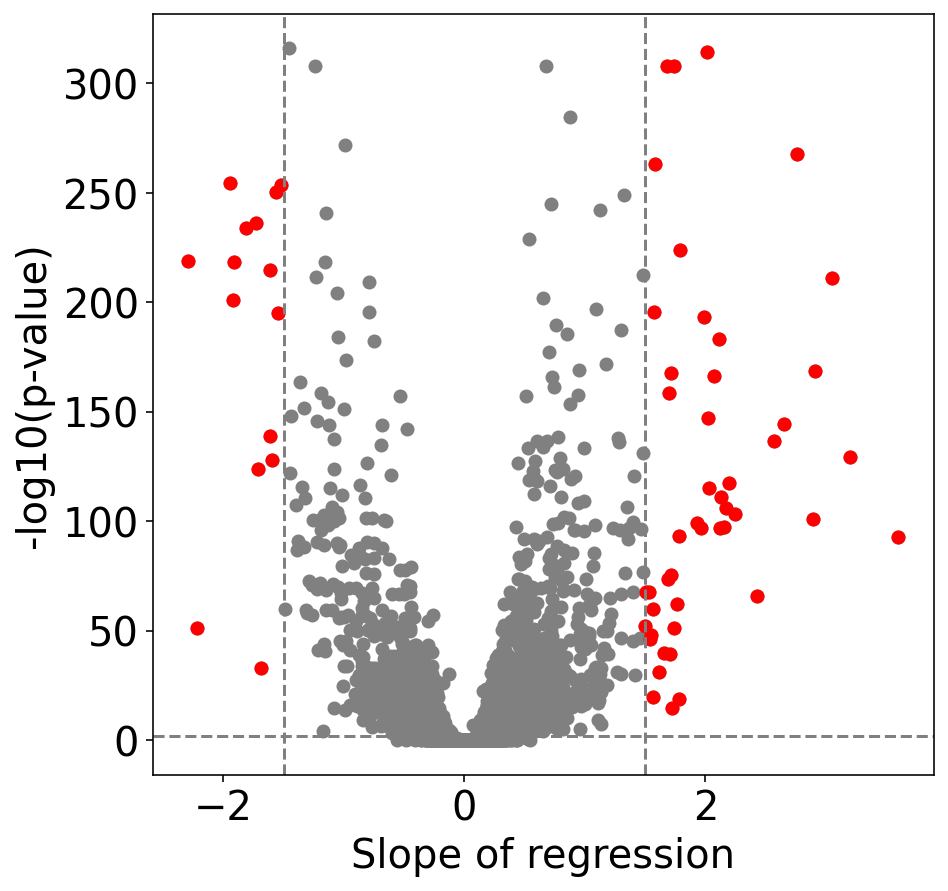

In [36]:
fig, ax = plt.subplots(figsize=(7,7))

xline = 1.5
yline = -np.log10(alpha)

x = markers_depth["coef"].values
y = -np.log10(markers_depth["p_f_corr"].values.astype(float))
labels = markers_depth["name"].str.split("_").apply(lambda x: "".join(x[:-1]))

ax.scatter(x, y, color="grey")

mask1 = np.logical_and(x>xline, y>yline)
ax.scatter(x[mask1], y[mask1], color="r")

mask2 = np.logical_and(x<-xline, y>yline)
ax.scatter(x[mask2], y[mask2], color="r")

mask = np.logical_or(mask1, mask2)
# for idx, (txt, xx, yy) in enumerate(zip(labels[mask], x[mask], y[mask])):
#     ax.annotate(txt, (xx, yy), ha="left")


ax.axvline(x=-xline, color="grey", linestyle="--")
ax.axhline(y=yline, color="grey", linestyle="--")
ax.axvline(x=xline, color="grey", linestyle="--")


ax.set(**{
    "xlabel": "Slope of regression",
    "ylabel": "-log10(p-value)"
})

plt.savefig(trackfig("../../figures/merfish_subclass_depth_regression_all_points_volcano.png", TRACKFIG, NB), bbox_inches='tight',dpi=300)


fig.show()

In [37]:
markers_depth = markers_depth.query(f"p_f_corr < {alpha}")

In [65]:
markers_depth.sort_values(["rsq_adj", "coef"]).tail(15)

,name,intercept,coef,p_f,p_f_corr,p_coef,p_coef_corr,rsq,rsq_adj,monotonic
444,Stmn3-201_ENSMUST00000103045,7.15265,0.72123,4.01958e-249,1.35982e-245,4.01958e-249,1.35982e-245,0.357091,0.356841,False
3075,Arhgdig-201_ENSMUST00000025019,5.11148,1.32082,4.24274e-253,1.43532e-249,4.24274e-253,1.43532e-249,0.361648,0.361399,False
648,Atp1a1-201_ENSMUST00000036493,5.21533,-1.56593,1.29462e-254,4.37971e-251,1.29462e-254,4.37971e-251,0.363375,0.363128,False
1026,Cux2-202_ENSMUST00000111752,1.46378,-1.52095,8.0299e-258,2.71652e-254,8.0299e-258,2.71652e-254,0.367017,0.366771,False
1007,Pop5-202_ENSMUST00000128830,5.63831,-1.94771,6.82878e-259,2.31018e-255,6.82878e-259,2.31018e-255,0.368228,0.367982,False
1173,Snca-201_ENSMUST00000114268,6.28498,1.5826,2.87467e-267,9.72501e-264,2.87467e-267,9.72501e-264,0.377622,0.37738,False
307,Slc1a2-202_ENSMUST00000080210,2.16356,2.7566,5.57572e-272,1.88627e-268,5.57572e-272,1.88627e-268,0.382846,0.382606,False
273,Chn1-215_ENSMUST00000231013,7.43223,-0.990391,5.52054e-276,1.8676e-272,5.52054e-276,1.8676e-272,0.38725,0.387012,False
1329,Ap2s1-201_ENSMUST00000086112,6.01601,0.874322,1.30408e-288,4.41171e-285,1.30408e-288,4.41171e-285,0.400935,0.400702,False
2980,Gap43-201_ENSMUST00000102817,5.23052,2.0137,1.97203e-318,6.67137e-315,1.97202e-318,6.67136e-315,0.432054,0.431833,False


## Visualizing WLS

In [39]:
mtx = isoform.layers["log1p"].todense()

In [83]:
specific_isoform = "Atp6ap2-201_ENSMUST00000033313"

vec = nd(mtx[:, isoform.var.eval(f"transcript_name == '{specific_isoform}'").values])
print(vec.shape)

data = [vec[isoform.obs.subclass_label.values == c] for c in layers]
len(data)

(6160,)


7

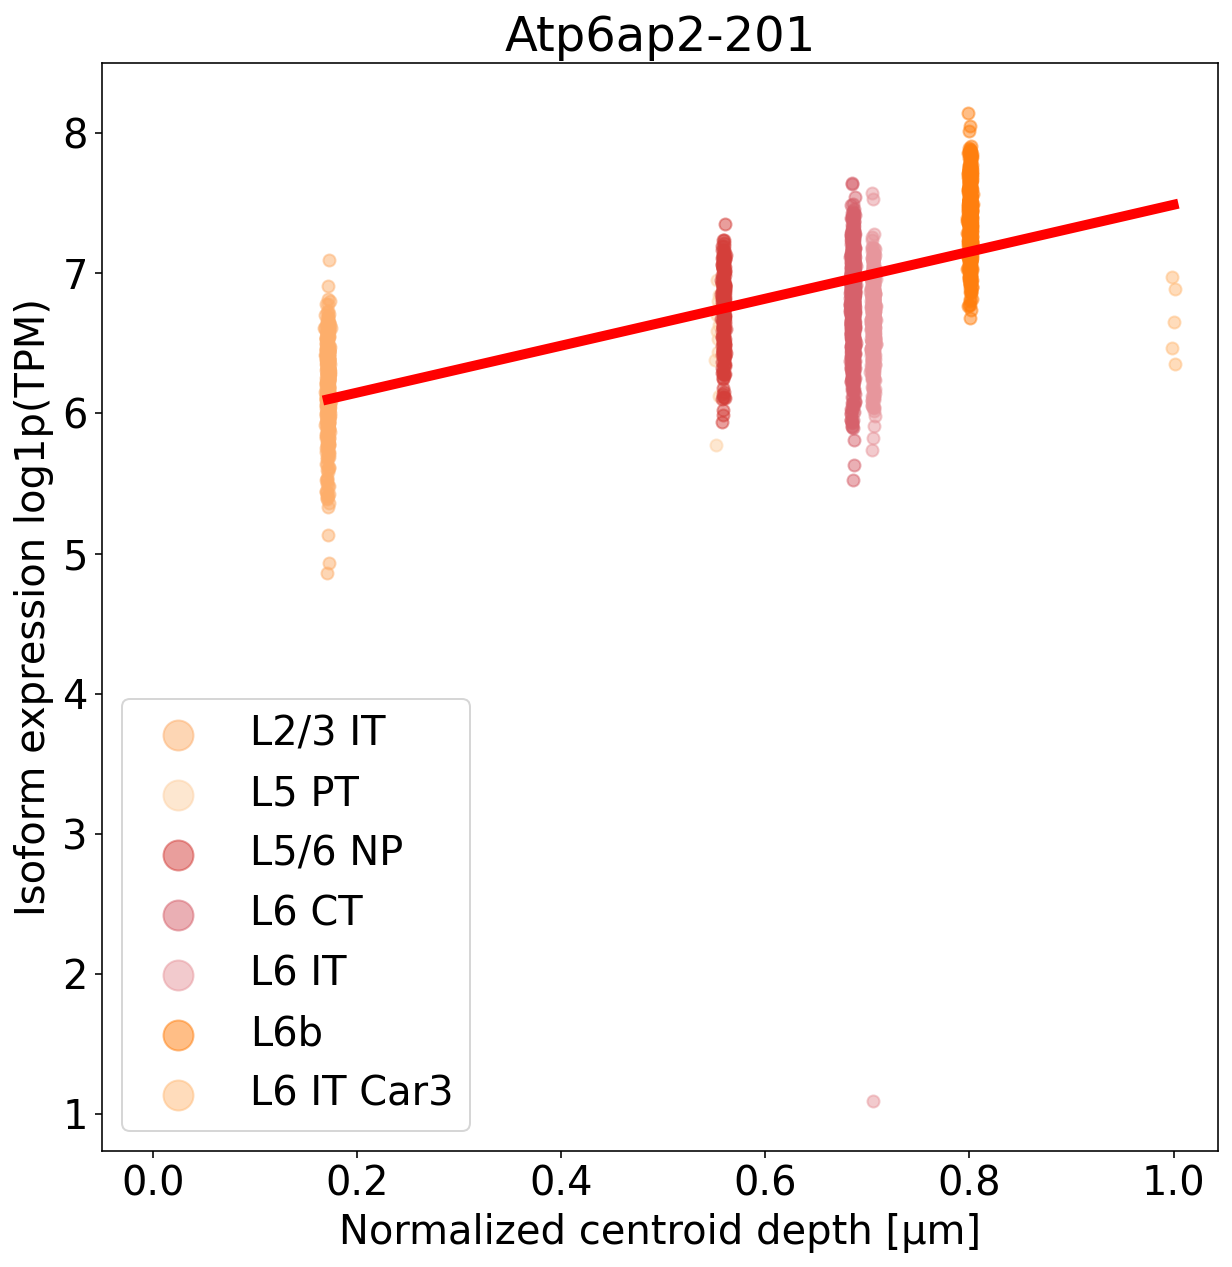

In [86]:
fig, ax = plt.subplots(figsize=(10,10))

labels = df.loc[layers]["normalized_depth"].values
x = np.linspace(min(labels), max(labels), 100)

c0, c1 =  nd(markers_depth.query(f"name=='{specific_isoform}'")[["intercept", "coef"]].values)
ax.plot(x, line(x, c0, c1), color="red", linewidth=5)

for didx, d in enumerate(data):
    jx = np.random.normal(labels[didx], 0.001, size=len(d))
    ax.scatter(jx, d, alpha=0.5, label=layers[didx], color=cluster_cmap[layers[didx]])

ax.set(**{
    "xlabel": "Normalized centroid depth [µm]",
    "ylabel": "Isoform expression log1p(TPM)",
    "title":f"{''.join(specific_isoform.split('_')[:-1])}",
    "xlim": (-0.05) 
})
ax.legend(loc="lower left", markerscale=2.5)

plt.savefig(trackfig("../../figures/merfish_subclass_depth_regression_{}.png".format(''.join(specific_isoform.split('_')[:-1])), TRACKFIG, NB), bbox_inches='tight',dpi=300)

fig.show()

In [87]:
markers_depth.monotonic.sum()

2

In [88]:
markers_depth.query("monotonic == True")

,name,intercept,coef,p_f,p_f_corr,p_coef,p_coef_corr,rsq,rsq_adj,monotonic
1213,Vmn1r47-202_ENSMUST00000227229,0.279105,-0.13114,2.09122e-34,7.07458e-31,2.09122e-34,7.07458e-31,0.0565049,0.0561382,True
2523,Vmn1r218-206_ENSMUST00000228348,1.50092,-0.427022,6.34534e-34,2.14663e-30,6.34534e-34,2.14663e-30,0.0556958,0.0553288,True


In [94]:
markers_depth.query("coef > 1.5").eval("monotonic == True").sum()

0

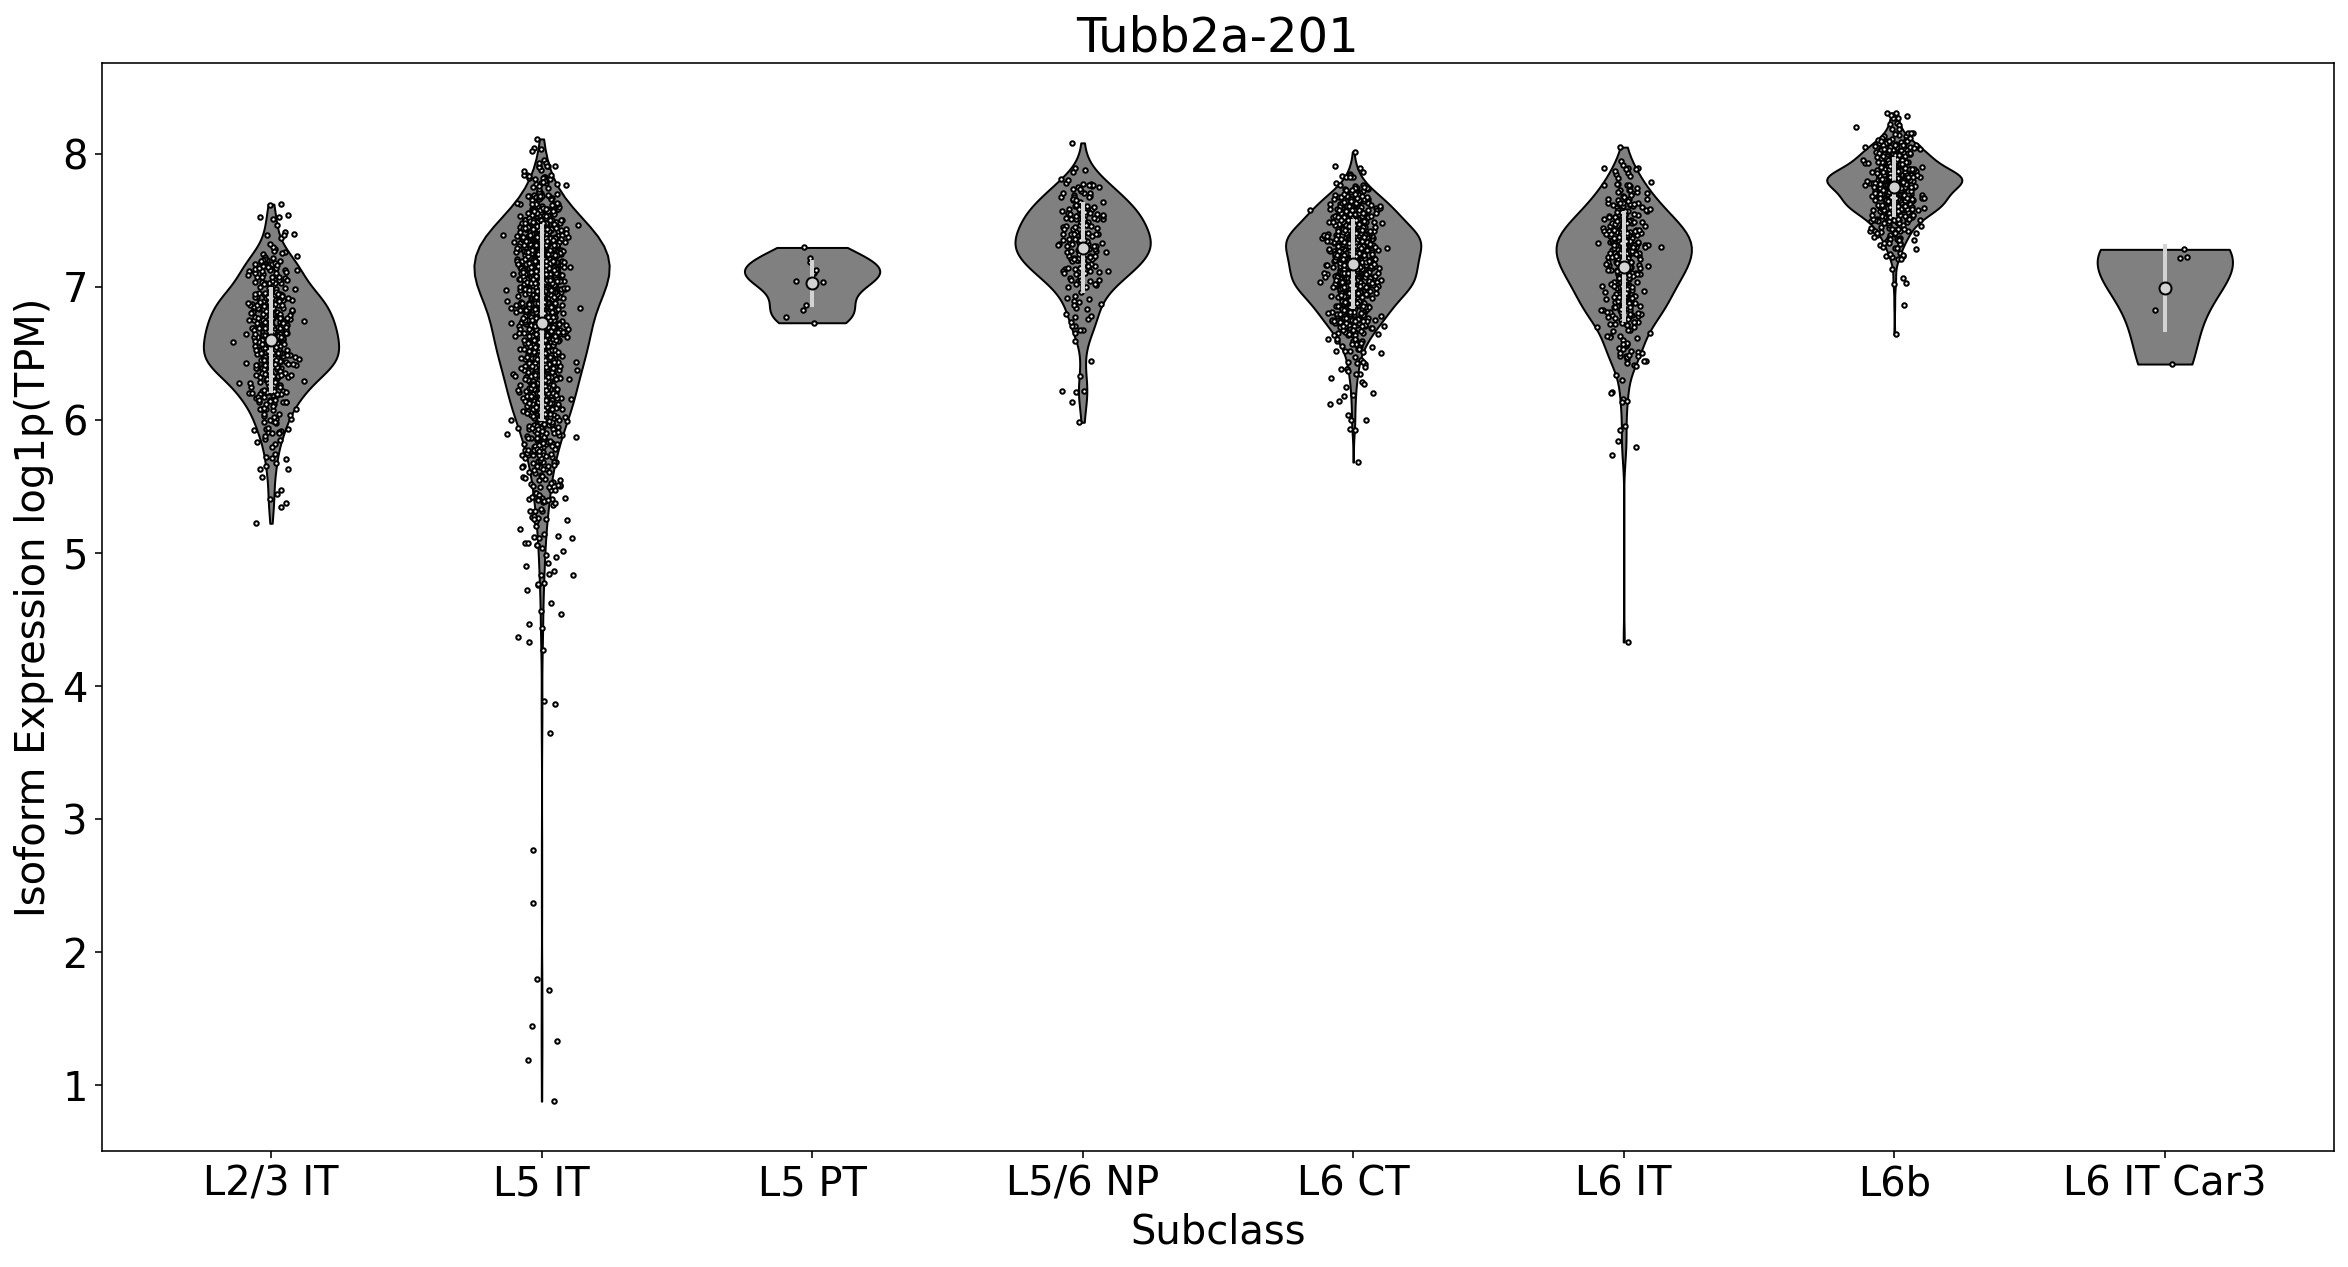

In [196]:
fig, ax = plt.subplots(figsize=(20,10))

labels = df.loc[layers]["centroid_depth"].values.astype(int)

violinplot(data, ax, xticklabels = layers)

ax.set(**{
    "xlabel": "Subclass",
    "ylabel": "Isoform Expression log1p(TPM)",
    "title":f"{''.join(specific_isoform.split('_')[:-1])}"

})

fig.show()

In [170]:
markers_depth

,name,intercept,coef,p_f,p_f_corr,p_coef,p_coef_corr,rsq,rsq_adj,monotonic,ll
1,Mrpl15-201_ENSMUST00000045689,3.26819,0.278658,5.57755e-08,0.000187127,5.57755e-08,0.000187127,0.00711258,0.0068724,False,NaN
3,Tcea1-201_ENSMUST00000081551,4.482,0.25378,3.29591e-10,1.10578e-06,3.29591e-10,1.10578e-06,0.00950837,0.00926878,False,NaN
4,Atp6v1h-201_ENSMUST00000044369,3.9286,0.264856,8.89296e-13,2.98359e-09,8.89296e-13,2.98359e-09,0.0122802,0.0120413,False,NaN
5,Atp6v1h-204_ENSMUST00000192698,5.66218,0.52559,1.80617e-71,6.05971e-68,1.80617e-71,6.05971e-68,0.0743969,0.074173,False,NaN
6,Cops5-201_ENSMUST00000027050,4.36639,0.616257,4.77918e-43,1.60342e-39,4.77918e-43,1.60342e-39,0.044738,0.044507,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3348,mt-Nd4-201_ENSMUST00000082414,7.13827,-0.224011,2.73947e-14,9.19091e-11,2.73947e-14,9.19091e-11,0.013913,0.0136745,False,NaN
3349,mt-Nd5-201_ENSMUST00000082418,6.25533,-0.154238,4.40102e-07,0.00147654,4.40102e-07,0.00147654,0.00615251,0.00591211,False,NaN
3351,mt-Cytb-201_ENSMUST00000082421,8.21229,-0.258915,2.7374e-20,9.18397e-17,2.7374e-20,9.18397e-17,0.0203941,0.0201571,False,NaN
3352,Vamp7-201_ENSMUST00000051100,4.06084,0.39547,2.03007e-09,6.81089e-06,2.03007e-09,6.81089e-06,0.00865823,0.00841842,False,NaN


In [718]:
markers_depth.query(f"name=='{specific_isoform}'")

,name,intercept,coef,p_f,monotonic,rsq,rsq_adj,p_f_corr
824,Hpca-201_ENSMUST00000030572,8.20429,-2.79241,2.84802e-265,False,0.253907,0.253726,1.97003e-260


In [177]:
markers_depth.to_csv(trackfig("../../tables/unordered/isoform_depth_DE.csv", TRACKFIG, NB))